In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')
%matplotlib inline  

import imp
import numpy as np
import os

import keras
import keras.backend
import keras.models

import innvestigate
import innvestigate.utils as iutils
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "./innvestigate/examples/utils.py")
mnistutils = imp.load_source("utils_mnist", "./innvestigate/examples/utils_mnist.py")

Using TensorFlow backend.


In [2]:

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.reshape((len(train_images),28,28,1))
test_images = test_images.reshape((len(test_images),28,28,1))

data_not_preprocessed = [train_images, train_labels, test_images, test_labels]

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

4423680/4422102 [==============================] - 0s 0us/step


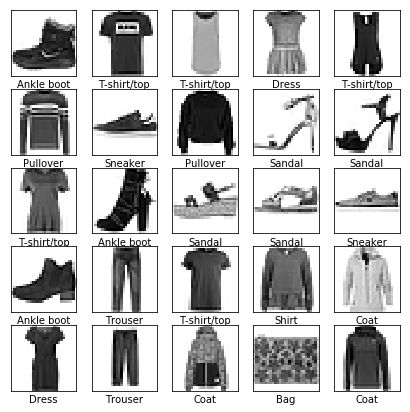

In [3]:
# to give you an overview of the data plot first 25 images with corresponding labels
plt.figure(figsize=(7,7))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_not_preprocessed[0][i].reshape((28,28)), cmap=plt.cm.binary)
    plt.xlabel(class_names[data_not_preprocessed[1][i]])
plt.show()

In [4]:
def create_preprocessing_f(X, input_range=[0, 1]):
    """
    Generically shifts data from interval [a, b] to interval [c, d].
    Assumes that theoretical min and max values are populated.
    """

    if len(input_range) != 2:
        raise ValueError(
            "Input range must be of length 2, but was {}".format(
                len(input_range)))
    if input_range[0] >= input_range[1]:
        raise ValueError(
            "Values in input_range must be ascending. It is {}".format(
                input_range))

    a, b = X.min(), X.max()
    c, d = input_range

    def preprocessing(X):
        # shift original data to [0, b-a] (and copy)
        X = X - a
        # scale to new range gap [0, d-c]
        X /= (b-a)
        X *= (d-c)
        # shift to desired output range
        X += c
        return X

    def revert_preprocessing(X):
        X = X - c
        X /= (d-c)
        X *= (b-a)
        X += a
        return X

    return preprocessing, revert_preprocessing

In [6]:

# Create preprocessing functions
input_range = [0, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(data_not_preprocessed[0], input_range)


In [14]:
#data_processed[0] = data_not_preprocessed[0]/250
#
#data_processed[1] = data_not_preprocessed[2]/250
#
#data_processed[0] = data_processed[0].reshape((len(data_processed[0]),28,28,1))
#data_processed[1] = data_processed[1].reshape((len(data_processed[1]),28,28,1))
#
data_processed = data_not_preprocessed[0] / 255, data_not_preprocessed[2] / 255




In [15]:
data = (data_processed[0], data_not_preprocessed[1],
        data_processed[1],data_not_preprocessed[3])
num_classes = len(np.unique(data[1]))
label_to_class_name = class_names

In [16]:
# Create & train model
if keras.backend.image_data_format == "channels_first":
    input_shape = (1, 28, 28)
else:
    input_shape = (28, 28, 1)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

#scores = mnistutils.train_model(model, data, batch_size=128, epochs=5)
#print("Scores on test set: loss=%s accuracy=%s" % tuple(scores))

model.compile(optimizer = 'adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# fit model to train data
# you cann add more 'iterations' by raising the parameter epochs
log = model.fit(data_processed[0], 
                data_not_preprocessed[1], 
                epochs = 5,         
                validation_data = (data_processed[1], data_not_preprocessed[3]))


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 177us/step - loss: 0.4682 - acc: 0.8263 - val_loss: 0.3525 - val_acc: 0.8665
Epoch 2/5
60000/60000 [==============================] - 10s 168us/step - loss: 0.2941 - acc: 0.8923 - val_loss: 0.2685 - val_acc: 0.8988
Epoch 3/5
60000/60000 [==============================] - 10s 169us/step - loss: 0.2511 - acc: 0.9078 - val_loss: 0.2758 - val_acc: 0.8986
Epoch 4/5
60000/60000 [==============================] - 10s 170us/step - loss: 0.2219 - acc: 0.9180 - val_loss: 0.2477 - val_acc: 0.9121
Epoch 5/5
60000/60000 [==============================] - 10s 168us/step - loss: 0.2021 - acc: 0.9261 - val_loss: 0.2492 - val_acc: 0.9113


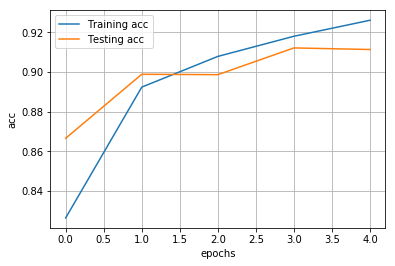

In [17]:

# make predictions for test data
predictions = model.predict(data_processed[1])

# plot accuracy per epoch
plt.plot(log.history['acc'], label='Training acc')
plt.plot(log.history['val_acc'], label='Testing acc')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.grid()

In [22]:
# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    return revert_preprocessing(X) / 255

noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input


# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE

    # Show input
    ("input",                 {},                       input_postprocessing,      "Input"),

    # Function
    ("gradient",              {"postprocess": "abs"},   mnistutils.graymap,        "Gradient"),
    ("smoothgrad",            {"noise_scale": noise_scale,
                               "postprocess": "square"},mnistutils.graymap,        "SmoothGrad"),
    ## Signal
    ("deconvnet",             {},                       mnistutils.bk_proj,        "Deconvnet"),
    ("guided_backprop",       {},                       mnistutils.bk_proj,        "Guided Backprop",),
    ("pattern.net",           {"pattern_type": "relu"}, mnistutils.bk_proj,        "PatternNet"),

    ## Interaction
    ("pattern.attribution",   {"pattern_type": "relu"}, mnistutils.heatmap,        "PatternAttribution"),
    ("deep_taylor.bounded",   {"low": input_range[0],
                               "high": input_range[1]}, mnistutils.heatmap,        "DeepTaylor"),
    ("input_t_gradient",      {},                       mnistutils.heatmap,        "Input * Gradient"),
    ("integrated_gradients",  {"reference_inputs": ri}, mnistutils.heatmap,        "Integrated Gradients"),
    ("deep_lift.wrapper",     {"reference_inputs": ri}, mnistutils.heatmap,        "DeepLIFT Wrapper - Rescale"),
    ("deep_lift.wrapper",     {"reference_inputs": ri, "nonlinear_mode": "reveal_cancel"},
                                                        mnistutils.heatmap,        "DeepLIFT Wrapper - RevealCancel"),
    ("lrp.z",                 {},                       mnistutils.heatmap,        "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           mnistutils.heatmap,        "LRP-Epsilon"),
]

In [23]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            **method[1])      # optional analysis parameters

    # Some analyzers require training.
    analyzer.fit(data[0], batch_size=256, verbose=1)
    analyzers.append(analyzer)

Epoch 1/1
235/235 [==============================] - 9s 37ms/step - loss: 6.0000 - broadcast_7_loss: 1.0000 - broadcast_8_loss: 1.0000 - broadcast_9_loss: 1.0000 - broadcast_10_loss: 1.0000 - broadcast_11_loss: 1.0000 - broadcast_12_loss: 1.0000
Epoch 1/1
235/235 [==============================] - 9s 38ms/step - loss: 6.0000 - broadcast_13_loss: 1.0000 - broadcast_14_loss: 1.0000 - broadcast_15_loss: 1.0000 - broadcast_16_loss: 1.0000 - broadcast_17_loss: 1.0000 - broadcast_18_loss: 1.0000


In [24]:
%%capture

n = 10
test_images = list(zip(data[2][:n], data[3][:n]))

analysis = np.zeros([len(test_images), len(analyzers), 28, 28, 3])
text = []


for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]
    
    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x)[0]
    prob = model.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" % label_to_class_name[y],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % label_to_class_name[y_hat] # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        # Analyze.
        a = analyzer.analyze(x)
        
        # Apply common postprocessing, e.g., re-ordering the channels for plotting.
        a = mnistutils.postprocess(a)
        # Apply analysis postprocessing, e.g., creating a heatmap.
        a = methods[aidx][2](a)
        # Store the analysis.
        analysis[i, aidx] = a[0]

<Figure size 432x288 with 0 Axes>

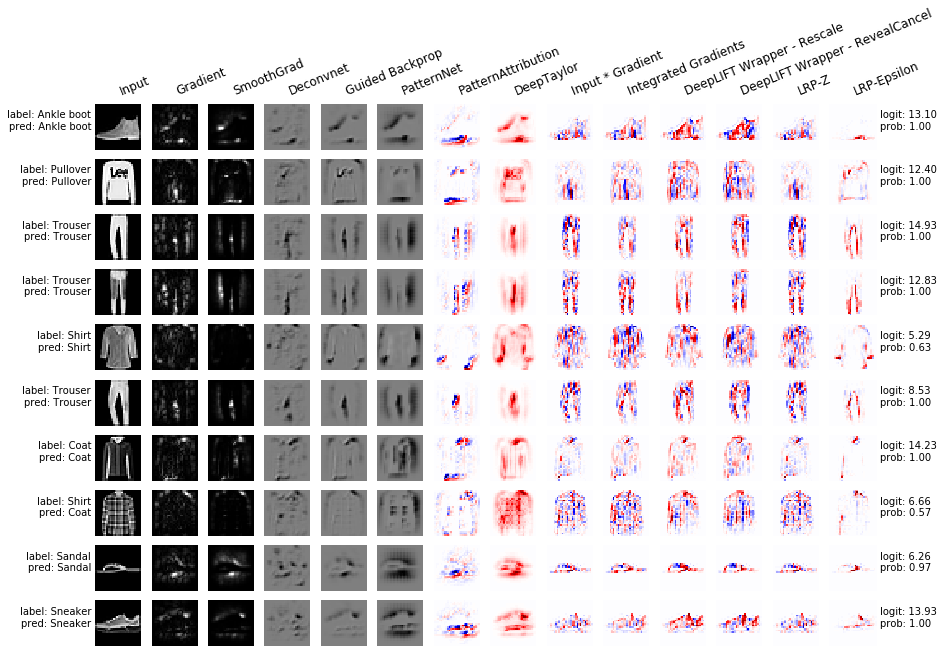

In [25]:
# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]), 'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

# Plot the analysis.
eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                       file_name=os.environ.get("PLOTFILENAME", None))